# Композиционная теория игр и нейросети: эксперимент

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru

In [1]:
pip install torch torchvision 'numpy<2'


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Данные

In [2]:
from dataclasses import dataclass

import torch

from torchvision import datasets, transforms

@dataclass
class Dataset:
    train_dataset: datasets.MNIST
    test_dataset: datasets.MNIST
    train_loader: torch.utils.data.DataLoader
    test_loader: torch.utils.data.DataLoader

def make_dataset(root: str, batch_size: int) -> Dataset:
    transform = transforms.Compose([
        transforms.ToTensor(),
        # https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(
        root=root,
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.MNIST(
        root=root,
        train=False,
        download=True,
        transform=transform
    )

    return Dataset(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )

dataset = make_dataset(root='./data', batch_size=64)


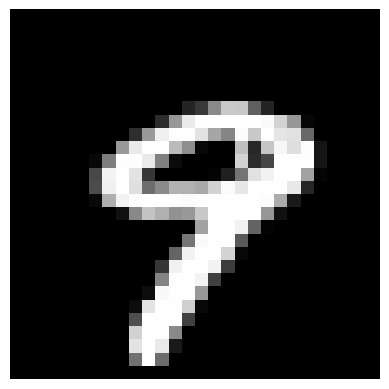

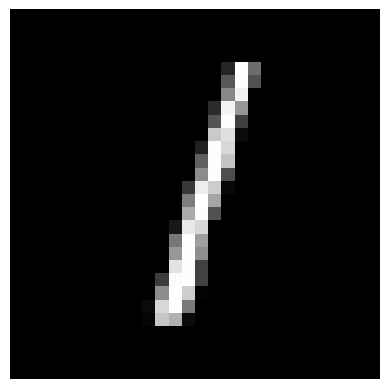

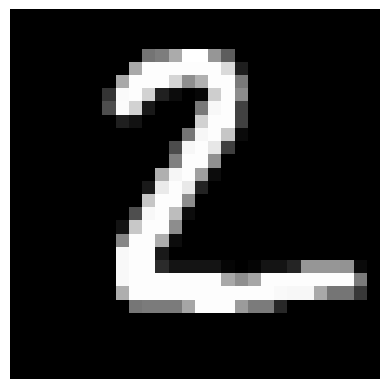

In [3]:
import matplotlib.pyplot as plt

def draw(tensor: torch.Tensor):
    plt.imshow(tensor, cmap='gray')
    plt.axis('off')
    plt.show()

draw(dataset.test_dataset.data[9])
draw(dataset.test_dataset.data[2])
draw(dataset.test_dataset.data[1])

## Модель

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(28 * 28, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## Обучение

In [10]:
import torch.optim as optim

def train(model: DigitRecognizer, loader, epochs, criterion, optimizer):
    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(loader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f'E{epoch + 1}/{epochs} S{i + 1}/{len(loader)} Loss={running_loss / 100:.4f}')
                running_loss = 0.0



In [11]:
model = DigitRecognizer()

train(
    model=model,
    loader=dataset.train_loader,
    epochs=5,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(
        model.parameters(),
        lr=0.001
    )
)

torch.save(model.state_dict(), 'digit_recognizer.pth')

E1/5 S100/938 Loss=0.4769
E1/5 S200/938 Loss=0.2553
E1/5 S300/938 Loss=0.1866
E1/5 S400/938 Loss=0.1697
E1/5 S500/938 Loss=0.1473
E1/5 S600/938 Loss=0.1449
E1/5 S700/938 Loss=0.1337
E1/5 S800/938 Loss=0.1338
E1/5 S900/938 Loss=0.1193
E2/5 S100/938 Loss=0.0884
E2/5 S200/938 Loss=0.0892
E2/5 S300/938 Loss=0.0922
E2/5 S400/938 Loss=0.0780
E2/5 S500/938 Loss=0.0987
E2/5 S600/938 Loss=0.0923
E2/5 S700/938 Loss=0.0814
E2/5 S800/938 Loss=0.0852
E2/5 S900/938 Loss=0.1043
E3/5 S100/938 Loss=0.0552
E3/5 S200/938 Loss=0.0563
E3/5 S300/938 Loss=0.0590
E3/5 S400/938 Loss=0.0644
E3/5 S500/938 Loss=0.0682
E3/5 S600/938 Loss=0.0683
E3/5 S700/938 Loss=0.0684
E3/5 S800/938 Loss=0.0671
E3/5 S900/938 Loss=0.0609
E4/5 S100/938 Loss=0.0528
E4/5 S200/938 Loss=0.0470
E4/5 S300/938 Loss=0.0359
E4/5 S400/938 Loss=0.0374
E4/5 S500/938 Loss=0.0437
E4/5 S600/938 Loss=0.0458
E4/5 S700/938 Loss=0.0465
E4/5 S800/938 Loss=0.0575
E4/5 S900/938 Loss=0.0502
E5/5 S100/938 Loss=0.0302
E5/5 S200/938 Loss=0.0412
E5/5 S300/93

## Валидация

In [13]:
import torch
model = DigitRecognizer()
model.load_state_dict(torch.load('digit_recognizer.pth'))

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataset.test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total * 100}%')

Accuracy: 96.8%


## Предсказания

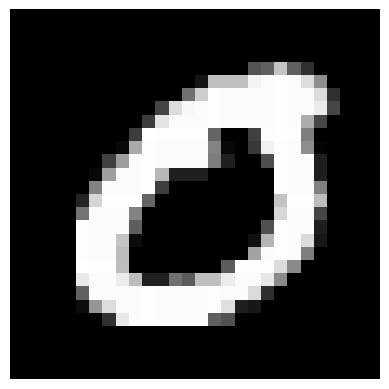

tensor([ 39.7960, -42.5919, -14.6548, -19.3560, -21.8696, -25.8399,  -7.7096,
        -29.1079, -15.5656,  -7.7908], grad_fn=<SelectBackward0>)


(0, tensor([0]))

In [18]:
import torch
model = DigitRecognizer()
model.load_state_dict(torch.load('digit_recognizer.pth'))

idx = 997 

draw(dataset.test_dataset.data[idx])

(x, y) = dataset.test_dataset[idx]

outputs = model(x)
_, predicted = torch.max(outputs.data, 1)
print(outputs[0])

(y, predicted)
